# Figure 3

The code below has been used to create Figure 3 in [the main paper](https://www.biorxiv.org/content/10.1101/2022.03.18.484903v2) as well as Figures S76-S87 in the [supplement](https://www.biorxiv.org/content/10.1101/2022.03.18.484903v2.supplementary-material).

Contact:
- Julia Koehler Leman: julia.koehler.leman@gmail.com
- Paweł Szczerbiak: pawel.szczerbiak@uj.edu.pl or p.szczerbiak@gmail.com

## Setting environment

Before running other cells, run the commands below in the terminal and activate the  `<env_name>` kernel in this notebook:

`conda create -n <env_name> numpy seaborn ipykernel`  
`conda activate <env_name>`  
`ipython kernel install --user --name=<env_name>`

Alternatively, one can use `virtualenv` instead of `conda` package manager.

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

## Global paths

**NOTE:** change the paths below appropriately.  
The first one should point to the `intermediate_data` folder downloded from the [Zenodo](https://zenodo.org/record/6477242#.Yoyp1PNBxqs) website.

In [2]:
INTER_DIR = Path('/path/to/intermediate_data/')
OUT_DIR = Path('./')  # current notebook directory

## Data generation

See `structure_functions/`

- GO terms' descriptions and `DeepFRI` predictions (in vector form) were obtained from the `json` files (one file per one MIP ID) in the main `metadata` folder (see [Zenodo](https://zenodo.org/record/6477242#.Yoyp1PNBxqs)).
- Note that only molecular function (MF) predictions have been used.

## Load data

#### Dictionary (`str: str`): `GO term: GO name`

In [3]:
goterms2names = pd.read_csv(INTER_DIR / 'structure_functions' / 'goterms_gonames.txt', 
                            header=None, index_col=0, sep='\t', squeeze=True).to_dict()

#### Dictionary (`str: list`): `Cluster ID: MIP IDs`

In [4]:
mip_clusters = pd.read_csv(INTER_DIR / 'structure_functions' / 'list_new_fold_clusters.txt', 
                            header=0, index_col=0, sep='\t', squeeze=True)
mip_clusters = mip_clusters.str.split(',').to_dict()

#### Dictionary (`str: list`): `GO term: scores`

In [5]:
mip2fxn = pd.read_csv(INTER_DIR / 'structure_functions' / 'fxn_new_fold_clusters.txt', 
                            header=None, index_col=0, sep=' ', squeeze=True)
mip2fxn = mip2fxn.str.split(',').apply(lambda x: list(map(float, x))).to_dict()

## Helper objects

In [6]:
l_mipid = []  # list of MIP IDs
l_number = []  # list of cluster IDs
l_scores = []  # list of tuples: (goterm, top10 scores)

# go through mip clusters and for each mip_id get the top10 functions
for c, mip_ids in mip_clusters.items():
    # go through each mip_id
    for m in mip_ids:
        # create dict of goterm:score
        goterms2score = dict(zip(goterms2names.keys(), mip2fxn[m]))
        # sort dictionary by value
        # sorted scores is list of tuples of (GOterms, score)
        sorted_scores = sorted(goterms2score.items(), 
                               key=lambda x: x[1], reverse=True)[0:10]
        l_mipid.append(m)
        l_number.append(c)
        l_scores.append(sorted_scores)

## Helper functions

In [7]:
def cossim(A, B):   
    """Compute cosine similarity"""
    res = np.dot(A, B) / (np.linalg.norm(A) * np.linalg.norm(B))
    return res

In [8]:
def filter_vals(x, threshold):
    """Replace values below threshold with 0"""
    return np.where(np.array(x) >= threshold, x, 0)

In [9]:
def get_fxn(mip_id):
    """Get GO names for top10 functions by MIP ID"""
    # get index in l_scores by mipid
    idx = l_mipid.index( mip_id )
    # use index to get top10 functions: 
    # returns list of tuples (goterm, score)
    fxns = l_scores[idx]
    # go through list of tuples and return tuples (score, goname)
    function_names = []
    for i in fxns:
        function_names.append((i[0], round(i[1], 5), 
                               goterms2names[i[0]]))
    return function_names

## Compute cossim matrix for filtered MIP ID functions

In [10]:
# Filtering thershold
# All function scores below the threhsold will be set to 0
THRESHOLD = 0.1

In [11]:
corr = np.zeros([len(l_mipid)+5, len(l_mipid)])
# random number at beginning
rand = random.uniform( 0.0, 1.0 )

# go through mip_ids, add 5 rows to visualize clusters
for m in range(0, len(l_mipid)+5):
    for n in range(0, len(l_mipid)):
        # add row with random color to visualize clusters
        if m == len(l_mipid):
            if l_number[n-1] != l_number[n]:
                rand = random.uniform( 0.0, 1.0 )
            corr[m][n] = rand
        # additional rows should have the same color as the added row for visualizing the clusters
        elif m > len(l_mipid):
            corr[m][n] = corr[len(l_mipid)][n]
        else:
            # cosine similarity
            corr[m][n] = cossim(filter_vals(mip2fxn[l_mipid[m]], THRESHOLD), 
                                filter_vals(mip2fxn[l_mipid[n]], THRESHOLD))

/tmp/ipykernel_3115069/4149716461.py:3: RuntimeWarning: invalid value encountered in double_scalars
  res = np.dot(A, B) / (np.linalg.norm(A) * np.linalg.norm(B))


## Helper functions for plotting

### Get correlations for sub clusters

In [12]:
def get_subcorr(clusternumbers, add_row):
    """Get sub-matrix from large correlation matrix
    Params:
        `clusternumbers` is list of cluster numbers
        `add_row` is 'y' or 'n' for adding a visual 
        row for cluster numbers
    """
    # get dimensions
    dim = sum([len( mip_clusters[i]) for i in clusternumbers])
    subcorr = np.zeros([dim, dim])

    # get mip ids in clusters and flatten lists
    cmip = [mip_clusters[i] for i in clusternumbers]
    cmips = [item for sublist in cmip for item in sublist]
    clustnum = [[i]*len(mip_clusters[i]) for i in clusternumbers]    
    clustnums = [item for sublist in clustnum for item in sublist]
    
    # go through mips
    for ii in range(0, len(cmips)):
        for jj in range(0, len(cmips)):
            # get indices of MIP IDs in `l_mipid` list 
            # to index correlation matrix
            idx1 = l_mipid.index(cmips[ii])
            idx2 = l_mipid.index(cmips[jj])
            subcorr[ii][jj] = corr[idx1][idx2]

    subcorr = subcorr.tolist()
    
    # append row for cluster numbers
    if add_row == 'y':
        subcorr.append( [i/161 for i in clustnums])
            
    return [subcorr, cmips, clustnums]

### Plot cossim per cluster - cluster each functional cluster into structural clusters

In [51]:
def plot_clustermap(clusternumber, figsize, save=False):
    """Plot structural clusters for specifc cluster number"""
    # get the data
    corr3, ids3, nums3 = get_subcorr([clusternumber], 'n')
    
    # turn it into a dataframe with columns and indices
    df = pd.DataFrame(corr3, index=ids3)
    
    # mask NANs in clustermap
    mask_na = -1.0
    df = df.fillna(mask_na)
    
    # plot the clustermap
    sns.set_theme(color_codes=True)
    g = sns.clustermap(df, cmap='plasma', figsize=(figsize,figsize), 
                       xticklabels=1, yticklabels=1, mask=df == mask_na, vmin=0, vmax=1)
    g.fig.suptitle('Cluster' + str(clusternumber), fontsize=20)
    
    # save if needed
    if save:
        plt.savefig(OUT_DIR / f'Figure_3_cluster={clusternumber}.png', 
                    bbox_inches='tight')
        labels = [el.get_text() for el in g.ax_heatmap.yaxis.get_majorticklabels()]
        pd.DataFrame(g.data2d.values, index=labels, columns=labels).\
            to_csv(OUT_DIR / f'Figure_3_cluster={clusternumber}.csv')
    # return dataframe (to be used for showing functions)
    plt.show()
    return df

### Get functions for specific indices

In [52]:
def get_fxns(index_list, df):
    """Print functions for indices
    Params:
        `index list` is list of indices in dataframe
        `df` is dataframe returned by `plot_clustermap()` function above
    """    
    for i in index_list:
        print (i, '-', df.index[i])
        ff = get_fxn(df.index[i])
        for jj in ff:
            print(jj)
        print()
    return

## Plots in the main paper

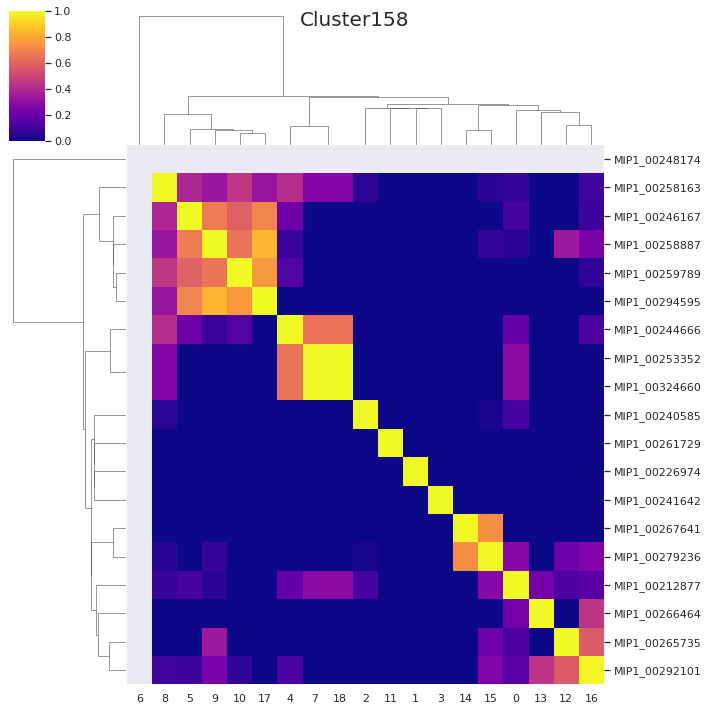

In [53]:
df = plot_clustermap(158, 10, True)

In [54]:
get_fxns([15, 11], df)

15 - MIP1_00279236
('GO:0016817', 0.47291, 'hydrolase activity, acting on acid anhydrides')
('GO:0016818', 0.47214, 'hydrolase activity, acting on acid anhydrides, in phosphorus-containing anhydrides')
('GO:0016462', 0.41686, 'pyrophosphatase activity')
('GO:0003677', 0.38798, 'DNA binding')
('GO:0017111', 0.38422, 'nucleoside-triphosphatase activity')
('GO:0016887', 0.23865, 'ATPase activity')
('GO:0097367', 0.22333, 'carbohydrate derivative binding')
('GO:0032553', 0.18778, 'ribonucleotide binding')
('GO:0140096', 0.13532, 'catalytic activity, acting on a protein')
('GO:0032555', 0.12888, 'purine ribonucleotide binding')

11 - MIP1_00261729
('GO:0003779', 0.18622, 'actin binding')
('GO:0008092', 0.17409, 'cytoskeletal protein binding')
('GO:0044877', 0.09642, 'protein-containing complex binding')
('GO:0003677', 0.06035, 'DNA binding')
('GO:0016651', 0.05426, 'oxidoreductase activity, acting on NAD(P)H')
('GO:0050660', 0.05262, 'flavin adenine dinucleotide binding')
('GO:0016829', 0.0

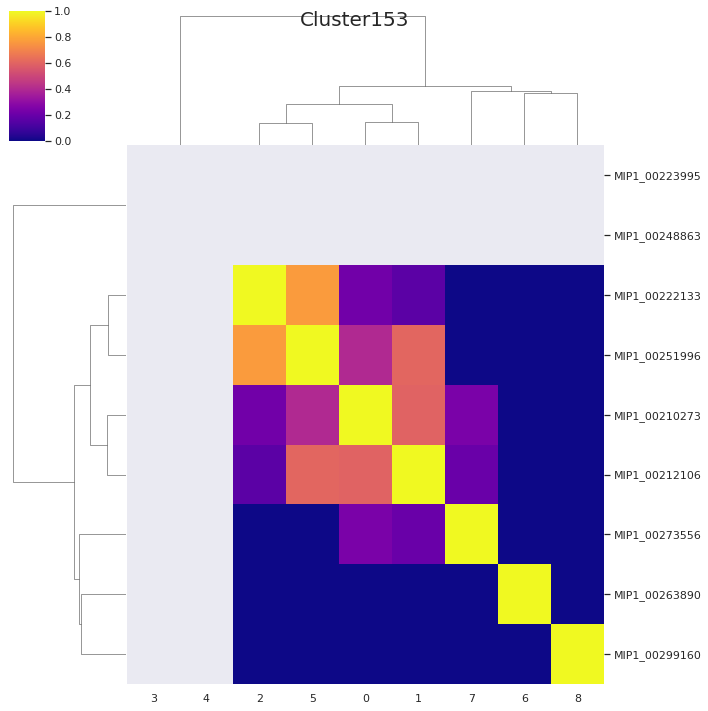

In [55]:
df = plot_clustermap(153, 10, True)

In [56]:
get_fxns([2, 1], df)

2 - MIP1_00222133
('GO:0008270', 0.21075, 'zinc ion binding')
('GO:0046914', 0.20006, 'transition metal ion binding')
('GO:0140096', 0.18871, 'catalytic activity, acting on a protein')
('GO:0003677', 0.14045, 'DNA binding')
('GO:0003723', 0.09307, 'RNA binding')
('GO:0016829', 0.07757, 'lyase activity')
('GO:0016788', 0.07639, 'hydrolase activity, acting on ester bonds')
('GO:0008092', 0.07348, 'cytoskeletal protein binding')
('GO:0005198', 0.0715, 'structural molecule activity')
('GO:0140110', 0.06325, 'transcription regulator activity')

1 - MIP1_00212106
('GO:0003677', 0.14445, 'DNA binding')
('GO:0042802', 0.13657, 'identical protein binding')
('GO:0098772', 0.13577, 'molecular function regulator')
('GO:0042803', 0.1334, 'protein homodimerization activity')
('GO:0019899', 0.11715, 'enzyme binding')
('GO:0046983', 0.10774, 'protein dimerization activity')
('GO:0008092', 0.10133, 'cytoskeletal protein binding')
('GO:0044877', 0.08963, 'protein-containing complex binding')
('GO:014009

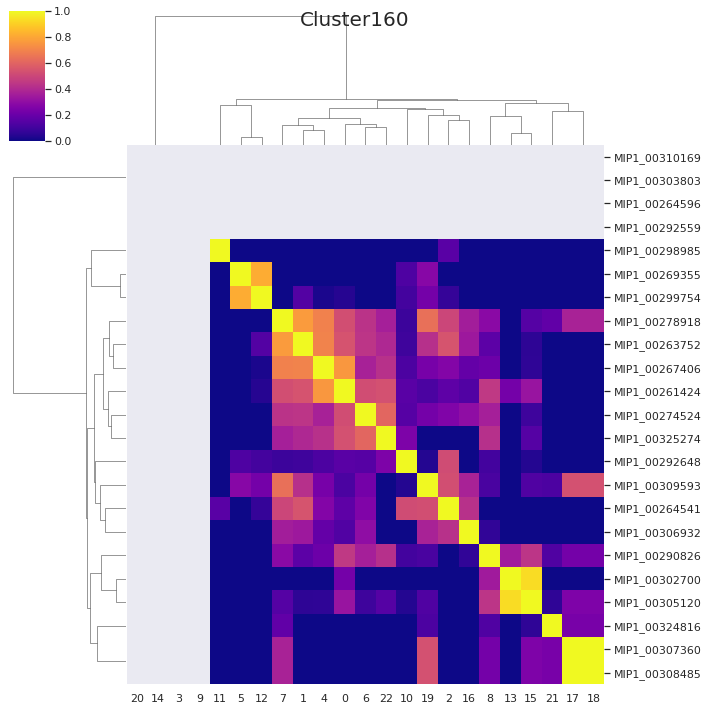

In [57]:
df = plot_clustermap(160, 10, True)

In [58]:
get_fxns([13, 15], df)

13 - MIP1_00302700
('GO:0016757', 0.21607, 'transferase activity, transferring glycosyl groups')
('GO:0016758', 0.15335, 'transferase activity, transferring hexosyl groups')
('GO:0008194', 0.04364, 'UDP-glycosyltransferase activity')
('GO:0003677', 0.03864, 'DNA binding')
('GO:0140096', 0.02283, 'catalytic activity, acting on a protein')
('GO:0003723', 0.0224, 'RNA binding')
('GO:0004518', 0.01913, 'nuclease activity')
('GO:0016788', 0.01497, 'hydrolase activity, acting on ester bonds')
('GO:0004519', 0.01484, 'endonuclease activity')
('GO:0140098', 0.01369, 'catalytic activity, acting on RNA')

15 - MIP1_00305120
('GO:0016757', 0.68559, 'transferase activity, transferring glycosyl groups')
('GO:0016758', 0.45895, 'transferase activity, transferring hexosyl groups')
('GO:0140096', 0.22159, 'catalytic activity, acting on a protein')
('GO:0008194', 0.18997, 'UDP-glycosyltransferase activity')
('GO:0016788', 0.13079, 'hydrolase activity, acting on ester bonds')
('GO:0009055', 0.05666, 'el

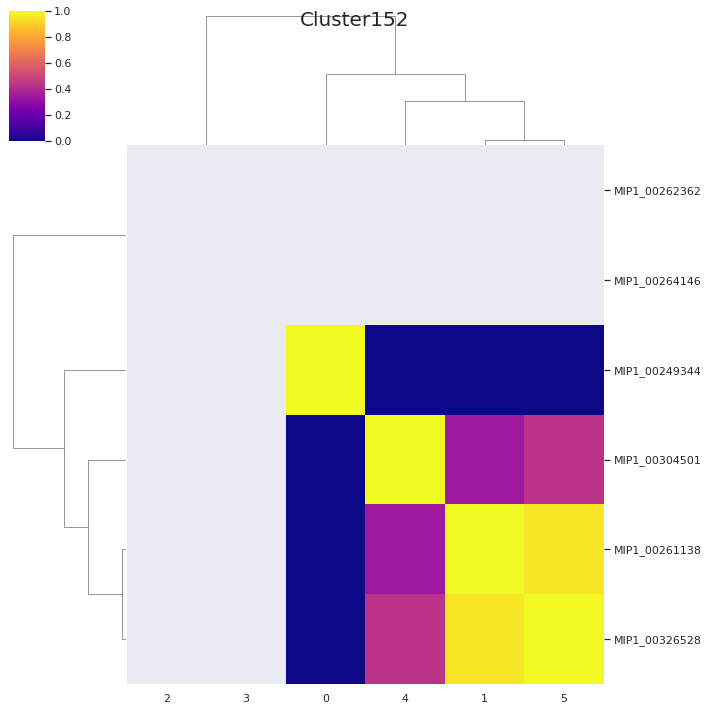

In [59]:
df = plot_clustermap(152, 10, True)

In [48]:
get_fxns([4, 1], df)

4 - MIP1_00304501
('GO:0038023', 0.26424, 'signaling receptor activity')
('GO:0004888', 0.25925, 'transmembrane signaling receptor activity')
('GO:0060089', 0.24639, 'molecular transducer activity')
('GO:0005215', 0.19265, 'transporter activity')
('GO:0022857', 0.15873, 'transmembrane transporter activity')
('GO:0030246', 0.13327, 'carbohydrate binding')
('GO:0042802', 0.11845, 'identical protein binding')
('GO:0097367', 0.1154, 'carbohydrate derivative binding')
('GO:0015075', 0.10897, 'ion transmembrane transporter activity')
('GO:0005509', 0.08969, 'calcium ion binding')

1 - MIP1_00261138
('GO:0015075', 0.99523, 'ion transmembrane transporter activity')
('GO:0022857', 0.99427, 'transmembrane transporter activity')
('GO:0005215', 0.9924, 'transporter activity')
('GO:0015318', 0.96844, 'inorganic molecular entity transmembrane transporter activity')
('GO:0008324', 0.95902, 'cation transmembrane transporter activity')
('GO:0022890', 0.94905, 'inorganic cation transmembrane transporter

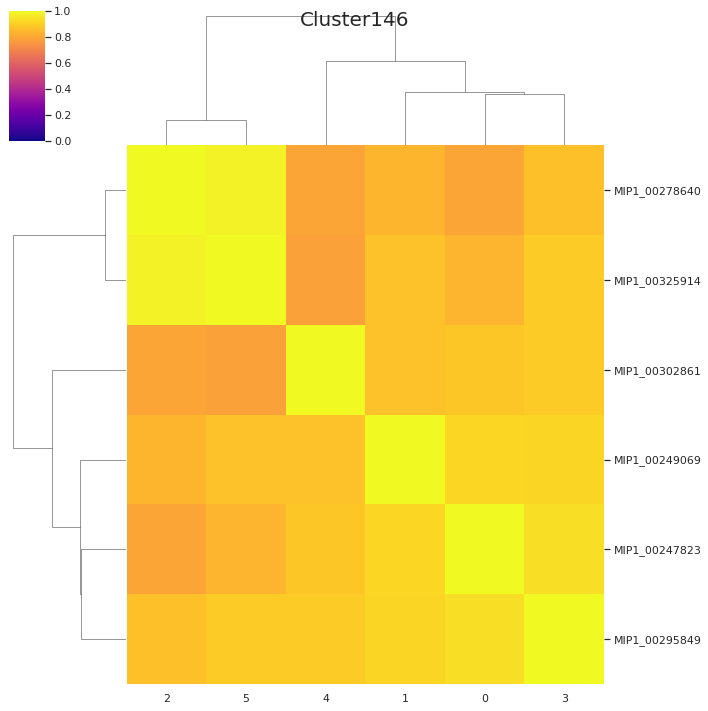

In [60]:
df = plot_clustermap(146, 10, True)

In [61]:
get_fxns([2, 5, 4, 3, 0, 1], df)

2 - MIP1_00278640
('GO:0005215', 0.69296, 'transporter activity')
('GO:0022857', 0.57942, 'transmembrane transporter activity')
('GO:0022804', 0.24048, 'active transmembrane transporter activity')
('GO:0015075', 0.18832, 'ion transmembrane transporter activity')
('GO:0008509', 0.11238, 'anion transmembrane transporter activity')
('GO:0015291', 0.10372, 'secondary active transmembrane transporter activity')
('GO:0015318', 0.09567, 'inorganic molecular entity transmembrane transporter activity')
('GO:0022853', 0.04126, 'active ion transmembrane transporter activity')
('GO:0046943', 0.03469, 'carboxylic acid transmembrane transporter activity')
('GO:0015297', 0.03346, 'antiporter activity')

5 - MIP1_00325914
('GO:0005215', 0.87803, 'transporter activity')
('GO:0022857', 0.8661, 'transmembrane transporter activity')
('GO:0015075', 0.33912, 'ion transmembrane transporter activity')
('GO:0022804', 0.29086, 'active transmembrane transporter activity')
('GO:0008509', 0.28631, 'anion transmemb

## Plots in the supplement

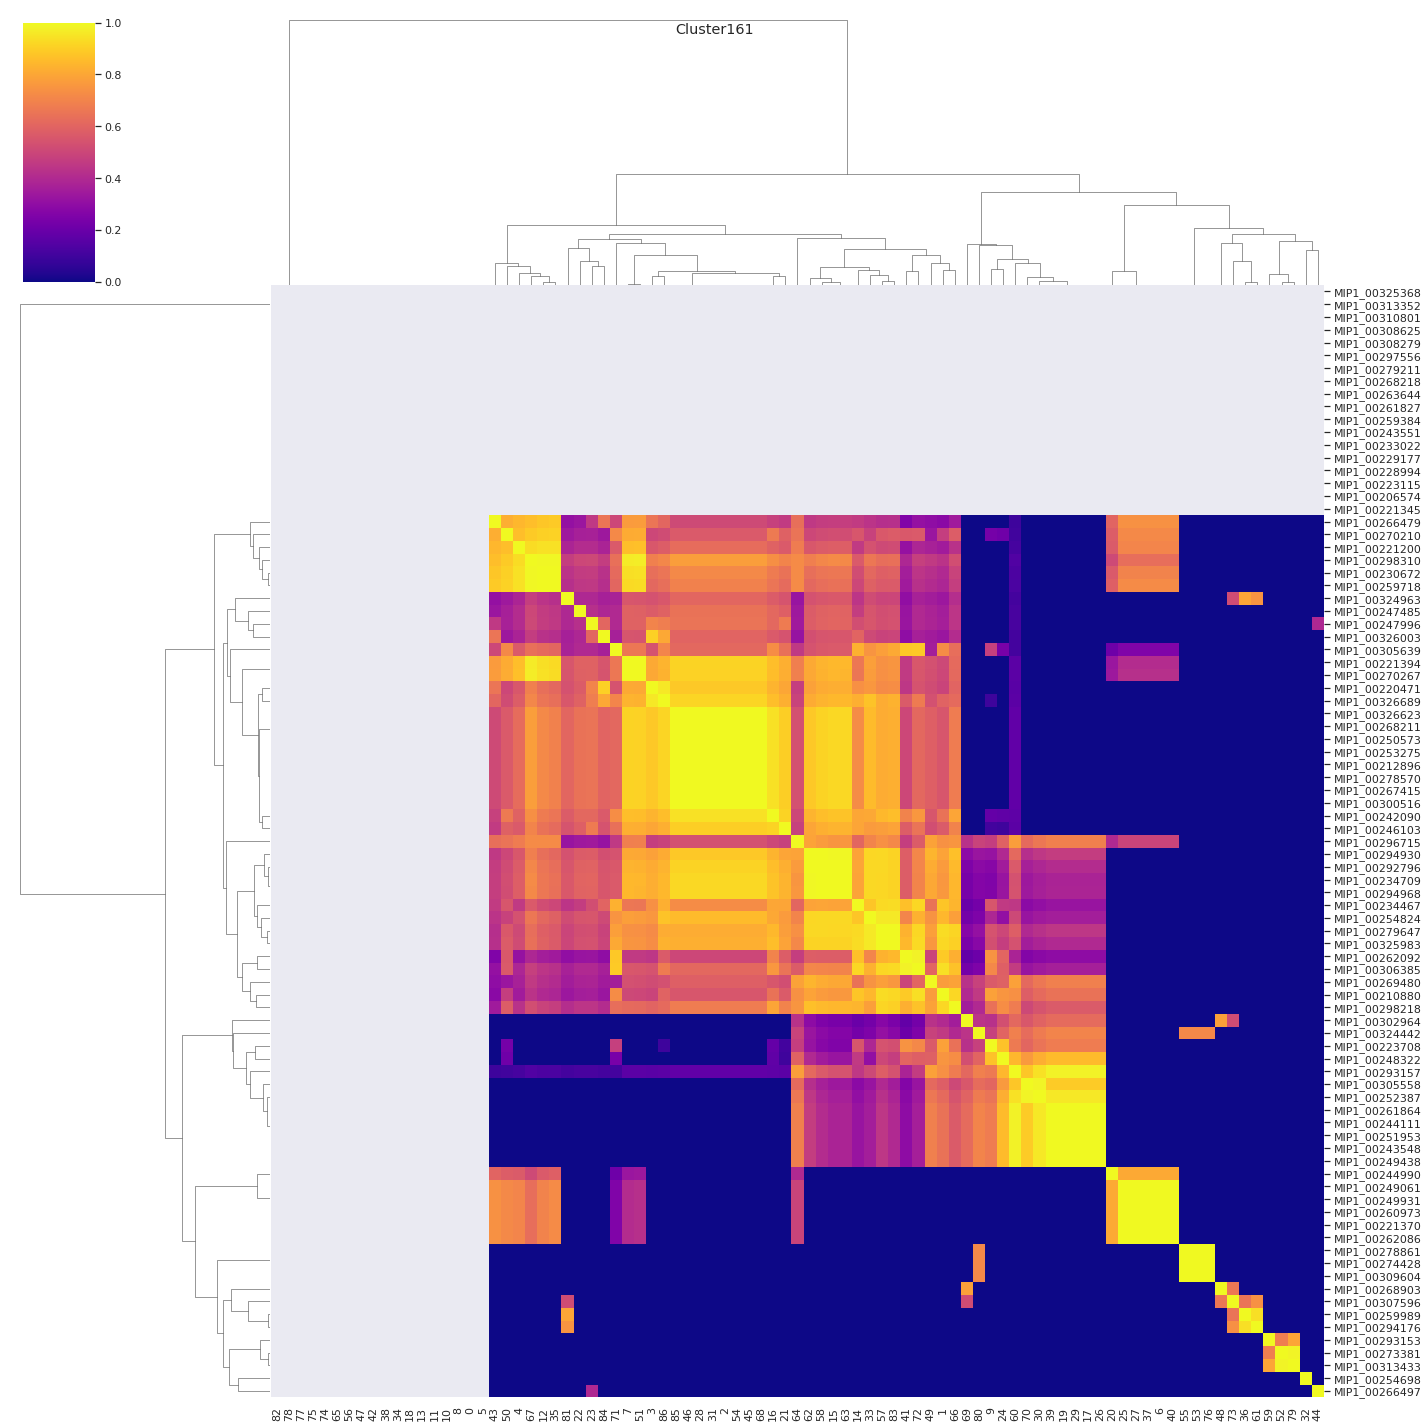

In [25]:
df = plot_clustermap(161, 20)

In [26]:
get_fxns([52, 79, 36, 61, 26, 39, 60, 54, 28, 86], df)

52 - MIP1_00273381
('GO:0016788', 0.18861, 'hydrolase activity, acting on ester bonds')
('GO:0140096', 0.17551, 'catalytic activity, acting on a protein')
('GO:0098772', 0.02129, 'molecular function regulator')
('GO:0008233', 0.0178, 'peptidase activity')
('GO:0004175', 0.01546, 'endopeptidase activity')
('GO:0052689', 0.01381, 'carboxylic ester hydrolase activity')
('GO:0003677', 0.00863, 'DNA binding')
('GO:0016298', 0.00807, 'lipase activity')
('GO:0019899', 0.00723, 'enzyme binding')
('GO:0030234', 0.00623, 'enzyme regulator activity')

79 - MIP1_00313433
('GO:0140096', 0.13999, 'catalytic activity, acting on a protein')
('GO:0016788', 0.10654, 'hydrolase activity, acting on ester bonds')
('GO:0098772', 0.02037, 'molecular function regulator')
('GO:0008233', 0.00836, 'peptidase activity')
('GO:0019899', 0.0078, 'enzyme binding')
('GO:0005102', 0.00724, 'signaling receptor binding')
('GO:0016790', 0.00646, 'thiolester hydrolase activity')
('GO:0003677', 0.00607, 'DNA binding')
('GO:

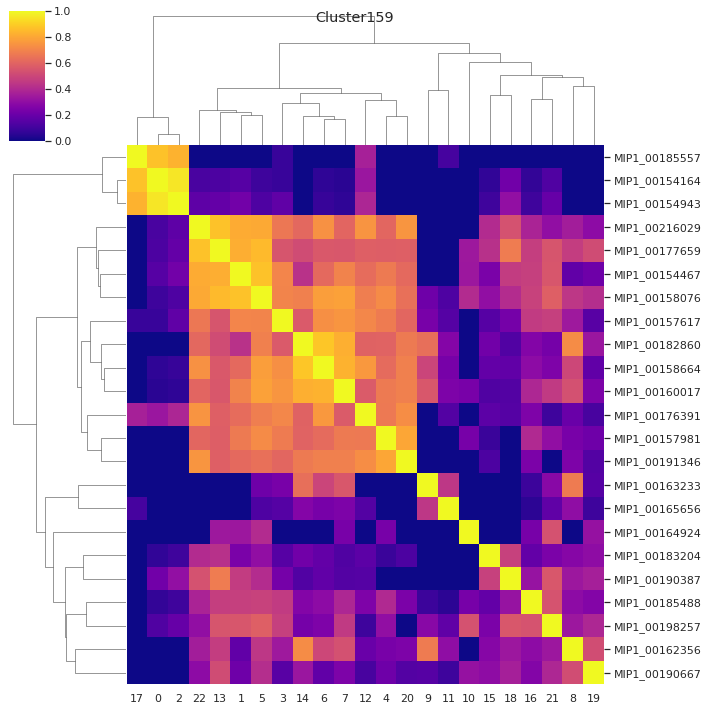

In [27]:
df = plot_clustermap(159, 10)

In [28]:
get_fxns([17, 0, 2, 6, 20, 7], df)

17 - MIP1_00185557
('GO:0051540', 0.60447, 'metal cluster binding')
('GO:0051536', 0.60068, 'iron-sulfur cluster binding')
('GO:0051537', 0.35941, '2 iron, 2 sulfur cluster binding')
('GO:0016667', 0.2419, 'oxidoreductase activity, acting on a sulfur group of donors')
('GO:0009055', 0.19262, 'electron transfer activity')
('GO:0051539', 0.1363, '4 iron, 4 sulfur cluster binding')
('GO:0008092', 0.09374, 'cytoskeletal protein binding')
('GO:0046914', 0.08295, 'transition metal ion binding')
('GO:0016671', 0.06811, 'oxidoreductase activity, acting on a sulfur group of donors, disulfide as acceptor')
('GO:0003779', 0.06515, 'actin binding')

0 - MIP1_00154164
('GO:0051540', 0.62482, 'metal cluster binding')
('GO:0051536', 0.62058, 'iron-sulfur cluster binding')
('GO:0046914', 0.19017, 'transition metal ion binding')
('GO:0008270', 0.15442, 'zinc ion binding')
('GO:0051537', 0.10224, '2 iron, 2 sulfur cluster binding')
('GO:0003677', 0.08548, 'DNA binding')
('GO:0051539', 0.08387, '4 iron, 

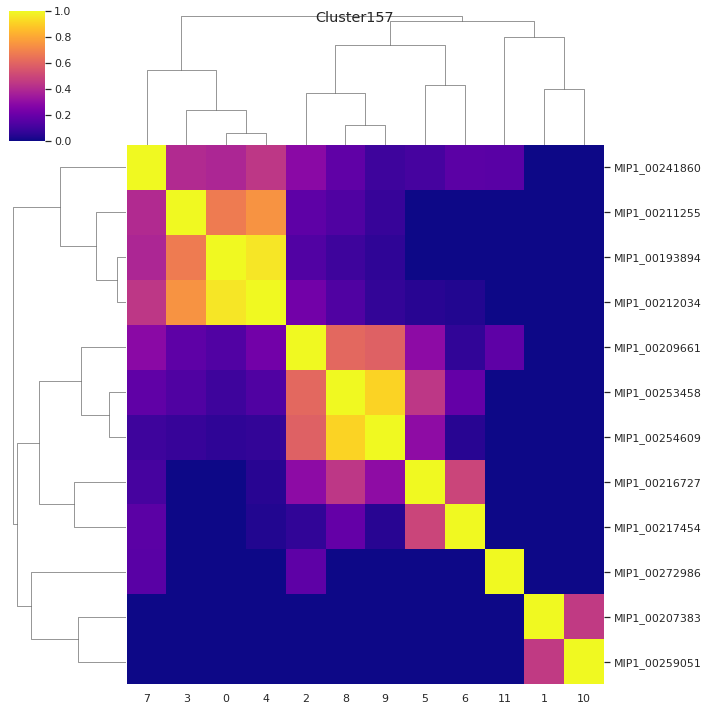

In [29]:
df = plot_clustermap(157, 10)

In [30]:
get_fxns([1, 10, 3, 0, 4], df)

1 - MIP1_00207383
('GO:0003779', 0.6624, 'actin binding')
('GO:0008092', 0.64312, 'cytoskeletal protein binding')
('GO:0051015', 0.54439, 'actin filament binding')
('GO:0044877', 0.50207, 'protein-containing complex binding')
('GO:0005509', 0.12174, 'calcium ion binding')
('GO:0004518', 0.07226, 'nuclease activity')
('GO:0097367', 0.06649, 'carbohydrate derivative binding')
('GO:0016788', 0.06351, 'hydrolase activity, acting on ester bonds')
('GO:0003677', 0.06175, 'DNA binding')
('GO:0032553', 0.05928, 'ribonucleotide binding')

10 - MIP1_00259051
('GO:0005509', 0.75927, 'calcium ion binding')
('GO:0008092', 0.36306, 'cytoskeletal protein binding')
('GO:0003779', 0.22041, 'actin binding')
('GO:0044877', 0.09008, 'protein-containing complex binding')
('GO:0003677', 0.01868, 'DNA binding')
('GO:0042802', 0.01763, 'identical protein binding')
('GO:0051015', 0.01717, 'actin filament binding')
('GO:0016788', 0.0081, 'hydrolase activity, acting on ester bonds')
('GO:0016817', 0.00433, 'hydr

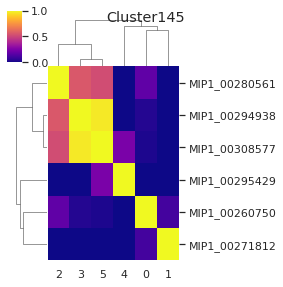

In [50]:
df = plot_clustermap(145, 4)

In [51]:
get_fxns([3, 5, 1, 4], df)

3 - MIP1_00294938
('GO:0008092', 0.21301, 'cytoskeletal protein binding')
('GO:0003779', 0.16914, 'actin binding')
('GO:0044877', 0.10561, 'protein-containing complex binding')
('GO:0005102', 0.09529, 'signaling receptor binding')
('GO:0003677', 0.08577, 'DNA binding')
('GO:0042802', 0.04967, 'identical protein binding')
('GO:0008289', 0.04244, 'lipid binding')
('GO:0140096', 0.03908, 'catalytic activity, acting on a protein')
('GO:0046914', 0.03754, 'transition metal ion binding')
('GO:0019899', 0.0373, 'enzyme binding')

5 - MIP1_00308577
('GO:0008092', 0.3661, 'cytoskeletal protein binding')
('GO:0003779', 0.35561, 'actin binding')
('GO:0044877', 0.14603, 'protein-containing complex binding')
('GO:0003677', 0.13217, 'DNA binding')
('GO:0051015', 0.04861, 'actin filament binding')
('GO:0008233', 0.03918, 'peptidase activity')
('GO:0042393', 0.03753, 'histone binding')
('GO:0042802', 0.03313, 'identical protein binding')
('GO:0140096', 0.03286, 'catalytic activity, acting on a protein

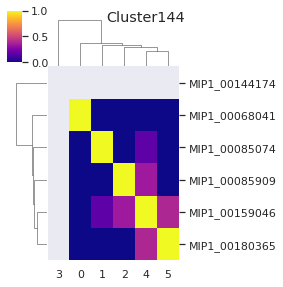

In [33]:
df = plot_clustermap(144, 4)

In [34]:
get_fxns([1, 5, 4], df)

1 - MIP1_00085074
('GO:0016829', 0.67135, 'lyase activity')
('GO:0004518', 0.1913, 'nuclease activity')
('GO:0016788', 0.16933, 'hydrolase activity, acting on ester bonds')
('GO:0003677', 0.03348, 'DNA binding')
('GO:0016835', 0.02187, 'carbon-oxygen lyase activity')
('GO:0046914', 0.01979, 'transition metal ion binding')
('GO:0004519', 0.01368, 'endonuclease activity')
('GO:0004540', 0.01053, 'ribonuclease activity')
('GO:0140098', 0.00608, 'catalytic activity, acting on RNA')
('GO:0016151', 0.00471, 'nickel cation binding')

5 - MIP1_00180365
('GO:0003723', 0.83263, 'RNA binding')
('GO:0140098', 0.24509, 'catalytic activity, acting on RNA')
('GO:0019843', 0.13255, 'rRNA binding')
('GO:0140101', 0.11349, 'catalytic activity, acting on a tRNA')
('GO:0005198', 0.11232, 'structural molecule activity')
('GO:0003677', 0.05397, 'DNA binding')
('GO:0016772', 0.05126, 'transferase activity, transferring phosphorus-containing groups')
('GO:0016779', 0.05012, 'nucleotidyltransferase activity')


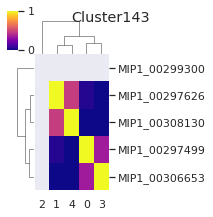

In [35]:
df = plot_clustermap(143, 3)

In [36]:
get_fxns([0, 3, 4], df)

0 - MIP1_00297499
('GO:0032555', 0.6997, 'purine ribonucleotide binding')
('GO:0017076', 0.69015, 'purine nucleotide binding')
('GO:0032553', 0.68772, 'ribonucleotide binding')
('GO:0097367', 0.65073, 'carbohydrate derivative binding')
('GO:0032559', 0.65005, 'adenyl ribonucleotide binding')
('GO:0030554', 0.64223, 'adenyl nucleotide binding')
('GO:0035639', 0.63218, 'purine ribonucleoside triphosphate binding')
('GO:0005524', 0.61175, 'ATP binding')
('GO:0016301', 0.45543, 'kinase activity')
('GO:0016772', 0.43254, 'transferase activity, transferring phosphorus-containing groups')

3 - MIP1_00306653
('GO:0016788', 0.291, 'hydrolase activity, acting on ester bonds')
('GO:0004518', 0.24549, 'nuclease activity')
('GO:0003677', 0.17512, 'DNA binding')
('GO:0016772', 0.13887, 'transferase activity, transferring phosphorus-containing groups')
('GO:0097367', 0.11578, 'carbohydrate derivative binding')
('GO:0140097', 0.10357, 'catalytic activity, acting on DNA')
('GO:0032553', 0.10175, 'ribon

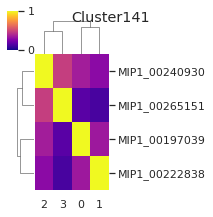

In [37]:
df = plot_clustermap(141, 3)

In [38]:
get_fxns([2, 3, 0, 1], df)

2 - MIP1_00240930
('GO:0003677', 0.31598, 'DNA binding')
('GO:0004519', 0.26216, 'endonuclease activity')
('GO:0140097', 0.25791, 'catalytic activity, acting on DNA')
('GO:0004518', 0.24973, 'nuclease activity')
('GO:0016788', 0.24807, 'hydrolase activity, acting on ester bonds')
('GO:0016772', 0.21515, 'transferase activity, transferring phosphorus-containing groups')
('GO:0016779', 0.20494, 'nucleotidyltransferase activity')
('GO:0003723', 0.20385, 'RNA binding')
('GO:0043565', 0.15939, 'sequence-specific DNA binding')
('GO:0140098', 0.14499, 'catalytic activity, acting on RNA')

3 - MIP1_00265151
('GO:0016772', 0.34228, 'transferase activity, transferring phosphorus-containing groups')
('GO:0097367', 0.33958, 'carbohydrate derivative binding')
('GO:0032553', 0.31502, 'ribonucleotide binding')
('GO:0016462', 0.2948, 'pyrophosphatase activity')
('GO:0016788', 0.29056, 'hydrolase activity, acting on ester bonds')
('GO:0016779', 0.28151, 'nucleotidyltransferase activity')
('GO:0004518',

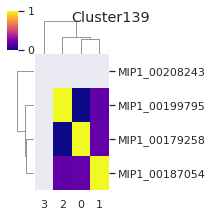

In [39]:
df = plot_clustermap(139, 3)

In [40]:
get_fxns([2, 1, 0], df)

2 - MIP1_00199795
('GO:0097367', 0.50772, 'carbohydrate derivative binding')
('GO:0032553', 0.49946, 'ribonucleotide binding')
('GO:0017076', 0.4794, 'purine nucleotide binding')
('GO:0032555', 0.4785, 'purine ribonucleotide binding')
('GO:0005524', 0.46708, 'ATP binding')
('GO:0030554', 0.46261, 'adenyl nucleotide binding')
('GO:0035639', 0.46213, 'purine ribonucleoside triphosphate binding')
('GO:0032559', 0.46155, 'adenyl ribonucleotide binding')
('GO:0016772', 0.26007, 'transferase activity, transferring phosphorus-containing groups')
('GO:0016301', 0.246, 'kinase activity')

1 - MIP1_00187054
('GO:0030234', 0.20121, 'enzyme regulator activity')
('GO:0098772', 0.1954, 'molecular function regulator')
('GO:0016853', 0.18103, 'isomerase activity')
('GO:0016857', 0.16718, 'racemase and epimerase activity, acting on carbohydrates and derivatives')
('GO:0008047', 0.15096, 'enzyme activator activity')
('GO:0016854', 0.14673, 'racemase and epimerase activity')
('GO:0140096', 0.13417, 'cata

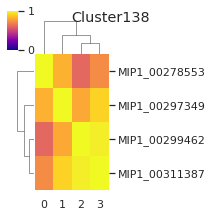

In [41]:
df = plot_clustermap(138, 3)

In [42]:
get_fxns([0, 1, 2, 3], df)

0 - MIP1_00278553
('GO:0003735', 0.20365, 'structural constituent of ribosome')
('GO:0003677', 0.15492, 'DNA binding')
('GO:0005198', 0.14804, 'structural molecule activity')
('GO:0019843', 0.05776, 'rRNA binding')
('GO:0003723', 0.03377, 'RNA binding')
('GO:0046914', 0.0042, 'transition metal ion binding')
('GO:0003700', 0.00317, 'DNA-binding transcription factor activity')
('GO:0016829', 0.00268, 'lyase activity')
('GO:0140110', 0.00241, 'transcription regulator activity')
('GO:0008270', 0.00118, 'zinc ion binding')

1 - MIP1_00297349
('GO:0005198', 0.7796, 'structural molecule activity')
('GO:0003735', 0.74854, 'structural constituent of ribosome')
('GO:0003723', 0.1953, 'RNA binding')
('GO:0019843', 0.0787, 'rRNA binding')
('GO:0003729', 0.07041, 'mRNA binding')
('GO:0000049', 0.03757, 'tRNA binding')
('GO:0061783', 0.0297, 'peptidoglycan muralytic activity')
('GO:0016903', 0.02806, 'oxidoreductase activity, acting on the aldehyde or oxo group of donors')
('GO:0008270', 0.02096, 'z

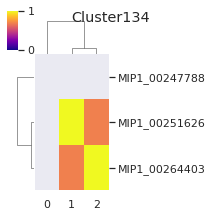

In [43]:
df = plot_clustermap(134, 3)

In [44]:
get_fxns([1, 2], df)

1 - MIP1_00251626
('GO:0016757', 0.40122, 'transferase activity, transferring glycosyl groups')
('GO:0016798', 0.26446, 'hydrolase activity, acting on glycosyl bonds')
('GO:0016758', 0.26312, 'transferase activity, transferring hexosyl groups')
('GO:0004553', 0.2209, 'hydrolase activity, hydrolyzing O-glycosyl compounds')
('GO:0016763', 0.15095, 'transferase activity, transferring pentosyl groups')
('GO:0008194', 0.12714, 'UDP-glycosyltransferase activity')
('GO:0046527', 0.06041, 'glucosyltransferase activity')
('GO:0030246', 0.04456, 'carbohydrate binding')
('GO:0016780', 0.02546, 'phosphotransferase activity, for other substituted phosphate groups')
('GO:0060089', 0.02343, 'molecular transducer activity')

2 - MIP1_00264403
('GO:0016757', 0.53021, 'transferase activity, transferring glycosyl groups')
('GO:0016763', 0.25278, 'transferase activity, transferring pentosyl groups')
('GO:0016758', 0.22021, 'transferase activity, transferring hexosyl groups')
('GO:0022857', 0.1915, 'transm

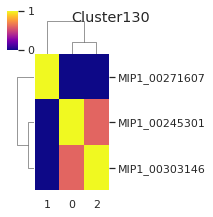

In [45]:
df = plot_clustermap(130, 3)

In [46]:
get_fxns([1, 0, 2], df)

1 - MIP1_00271607
('GO:0005509', 0.13451, 'calcium ion binding')
('GO:0042802', 0.08886, 'identical protein binding')
('GO:0030674', 0.08877, 'protein-macromolecule adaptor activity')
('GO:0060090', 0.08032, 'molecular adaptor activity')
('GO:0044877', 0.05738, 'protein-containing complex binding')
('GO:0008092', 0.05488, 'cytoskeletal protein binding')
('GO:0005198', 0.05486, 'structural molecule activity')
('GO:0098772', 0.04252, 'molecular function regulator')
('GO:0008289', 0.03933, 'lipid binding')
('GO:0046914', 0.03895, 'transition metal ion binding')

0 - MIP1_00245301
('GO:0022857', 0.21727, 'transmembrane transporter activity')
('GO:0005215', 0.2102, 'transporter activity')
('GO:0015075', 0.19751, 'ion transmembrane transporter activity')
('GO:0008324', 0.12711, 'cation transmembrane transporter activity')
('GO:0022890', 0.09208, 'inorganic cation transmembrane transporter activity')
('GO:0015318', 0.08331, 'inorganic molecular entity transmembrane transporter activity')
('GO

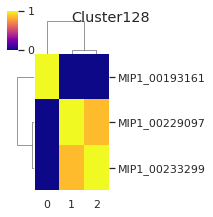

In [47]:
df = plot_clustermap(128, 3)

In [48]:
get_fxns([0, 1, 2], df)

0 - MIP1_00193161
('GO:0140096', 0.1351, 'catalytic activity, acting on a protein')
('GO:0019787', 0.09513, 'ubiquitin-like protein transferase activity')
('GO:0004842', 0.0746, 'ubiquitin-protein transferase activity')
('GO:0008092', 0.06782, 'cytoskeletal protein binding')
('GO:0042802', 0.05858, 'identical protein binding')
('GO:0061659', 0.05229, 'ubiquitin-like protein ligase activity')
('GO:0061630', 0.04555, 'ubiquitin protein ligase activity')
('GO:0005215', 0.0423, 'transporter activity')
('GO:0003779', 0.03834, 'actin binding')
('GO:0008270', 0.03181, 'zinc ion binding')

1 - MIP1_00229097
('GO:0003735', 0.96775, 'structural constituent of ribosome')
('GO:0005198', 0.96306, 'structural molecule activity')
('GO:0019843', 0.91474, 'rRNA binding')
('GO:0003723', 0.89073, 'RNA binding')
('GO:0008097', 0.00085, '5S rRNA binding')
('GO:0070181', 0.00083, 'small ribosomal subunit rRNA binding')
('GO:0003677', 0.00071, 'DNA binding')
('GO:0003729', 0.0006, 'mRNA binding')
('GO:007018